# DAML - Sample Bias

Michal Grochmal <michal.grochmal@city.ac.uk>

For the *normal distribution* we saw that the population standard deviation and variance are
(here we use the $\mu$ symbol for the population mean):

$$
\begin{align}
\sigma^2 &= \frac{1}{N} \sum_{i=0}^{N} (x_i - \mu)^2 \\
\sigma &= \sqrt{\frac{1}{N} \sum_{i=0}^{N} (x_i - \mu)^2} \\
\end{align}
$$

Whilst for a sample, one degree of freedom is introduced and instead we have the following.
To differentiate population and sample statistics we will use a common convention,
and call the sample standard deviation $s$, instead of $\sigma$.

$$
\begin{align}
s^2 &= \frac{1}{n-1} \sum_{i=0}^{n} (x_i - \bar{x})^2 \\
s &= \sqrt{\frac{1}{n-1} \sum_{i=0}^{n} (x_i - \bar{x})^2} \\
\end{align}
$$

What we will try to do is to understand why this $-1$ is added to the equation.

## Biased Estimator

An estimator attempts to find a value of the population based on a handful of observations.
A good estimator will find the correct value for the population most of the time.
A biased estimator will find an incorrect value most of the time, yet a biased
estimator will get the value wrong by an amount that can be estimated and corrected.

The sample variance ($s^2$) is a corrected biased estimator of the population variance.
And consequently the sample standard deviation is such an estimator as well.
We will try to understand this bias and how it results in the unbiased (i.e. bias-corrected)
equations above.

Here we will call $\mu$ the real (population) mean and $\bar{x}$ the mean of the sample,
$\sigma^2$ is the population variance as normal but $s_n^2$ is the sample variance
*without* bias correction.

$$
s_n^2 = \frac{1}{n} \sum_{i=0}^{n} (x_i - \bar{x})^2 \\
$$

Sometimes we will also use $p$ to mean the full population
and $s$ to mean the full sample of values/measures.

We will first prove that there really is a bias when taking the variance
of a sample to estimate the variance of a population.

## Computational Proof

Since we can simply generate a population and then sample it,
let's just do it a couple of times for bigger and bigger populations
and see if the equation works.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')

If we generate a population, sample it and plot the histograms
of the population against the sample, then the sample histogram will
be always contained within the population histogram.
If we normalize the histograms the sample histogram can vertically extend
beyond the population histogram, but can never extend laterally beyond the
population histogram.

This makes sense.  Since the sample can only contain data points from
within the population it will never contain values from outside the
range within the population.  The range of values in the sample can
be smaller than the range of value within the population but can
never be bigger.  We can visualize this.

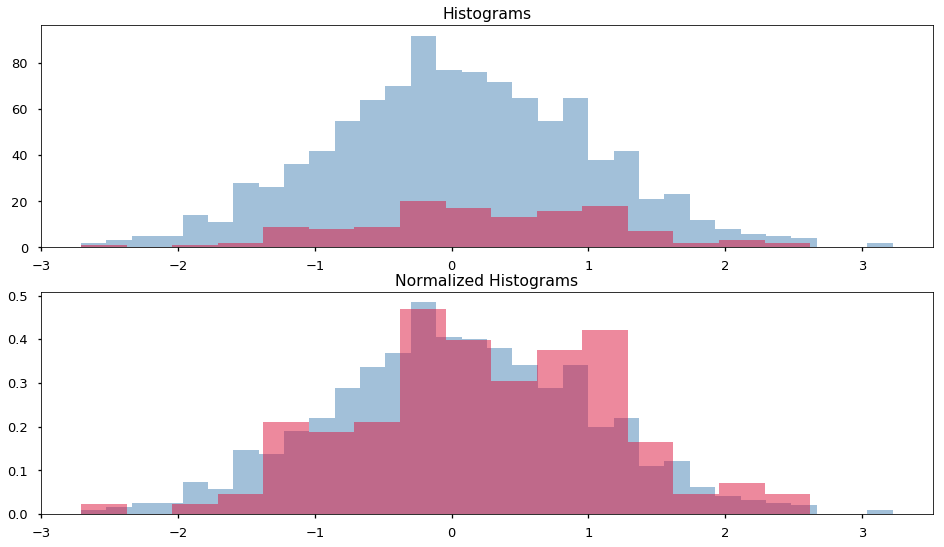

In [3]:
rng = np.random.RandomState()
pop_size = 1024
bins = np.sqrt(pop_size)
pop = rng.randn(pop_size)
sample = rng.choice(pop, pop_size//8, replace=False)
fig, ax = plt.subplots(2, figsize=(16, 9))
ax[0].hist(pop, bins=32, alpha=0.5, color='steelblue')
ax[0].hist(sample, bins=16, alpha=0.5, color='crimson')
ax[0].set_title('Histograms')
ax[1].hist(pop, bins=32, alpha=0.5, density=True, color='steelblue')
ax[1].hist(sample, bins=16, alpha=0.5, density=True, color='crimson')
ax[1].set_title('Normalized Histograms');

A way to formulate the idea that the range of values of the sample can be smaller
but cannot be bigger than the range of the population is to say that.

$$
|max(p) - min(p)| \geq |max(s) - min(s)|
$$

Geometrically the standard deviation can be understood as $\sim34.1\%$ of
the range of values of the normal distribution.
This allows us for a simple experiment:
We generate several populations, sample them, and then compare the geometric
understanding the standard deviation between the population and the sample.
We will print out the ratio:

$$
\frac{|max(s) - min(s)|}{|max(p) - min(p)|}
$$

Note that this is independent of the $\sim34.1\%$ geometric understanding
of the standard deviation, this is because this number would appear both
in the numerator and the denominator of the fraction above.

In [135]:
rng = np.random.RandomState()
def std_ratio(pop_size, sample_ratio=None, sample_size=None, repeat=1, dof=1):
    pop = rng.randn(pop_size, repeat)
    if not sample_size:
        sample_size = pop_size//sample_ratio
    if sample_size > pop_size:
        sample_size = pop_size
    choice = rng.randint(pop_size, size=sample_size)
    sample = pop[choice, :]
    range_pop = np.abs(np.max(pop, axis=0) - np.min(pop, axis=0))
    range_sample = np.abs(np.max(sample, axis=0) - np.min(sample, axis=0))
    correction = sample_size / (sample_size - dof)
    stdr = np.mean(range_sample*correction/range_pop)
    return stdr, stdr*correction


for p_size in [1024, 2048, 4096]:
    print(std_ratio(p_size, sample_ratio=8, repeat=16))

(0.7956481373121909, 0.801913083275279)
(0.8390457727086573, 0.8423361482879069)
(0.8441145156200793, 0.8457664031261851)


We can see that the sample standard deviation (and therefore variance)
will be smaller than that of the entire population.

That said, the values are quite varied,
this is because out population sizes are quite small.
We will need to evaluate the change in population size,
and sample size separately and try to draw conclusions
as they grow into big populations.

For a start let's see what we ought to expect using a simple
sample size of $12.5\%$ or the population.

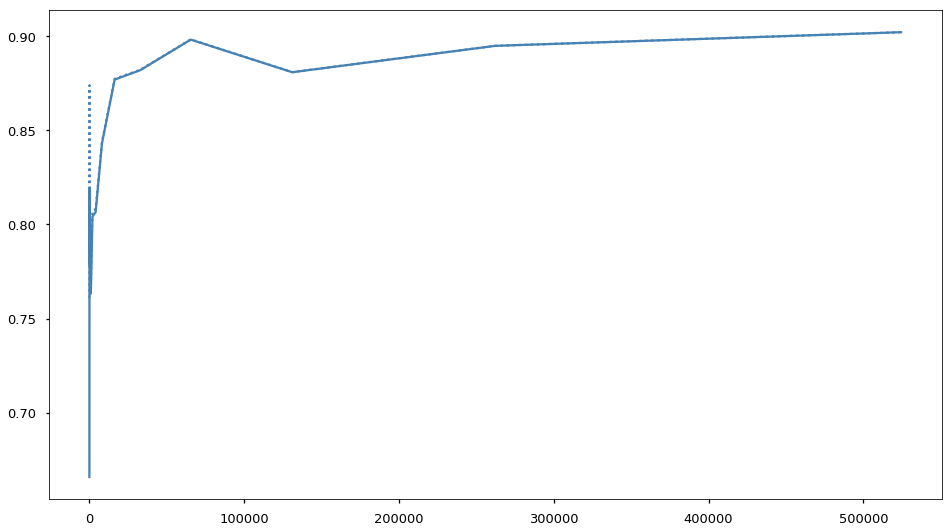

In [146]:
sizes = []
ratios = []
corrected = []
for p_size in map(lambda x: 2**x, range(6, 20)):
    sizes.append(p_size)
    sr, src = std_ratio(p_size, sample_ratio=8, repeat=16)
    ratios.append(sr)
    corrected.append(src)
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(sizes, ratios, color='steelblue')
ax.plot(sizes, corrected, ':', color='steelblue');

That looks promising, the funtion approaches a specific value.

Next let's try a couple of fixed sample sizes.

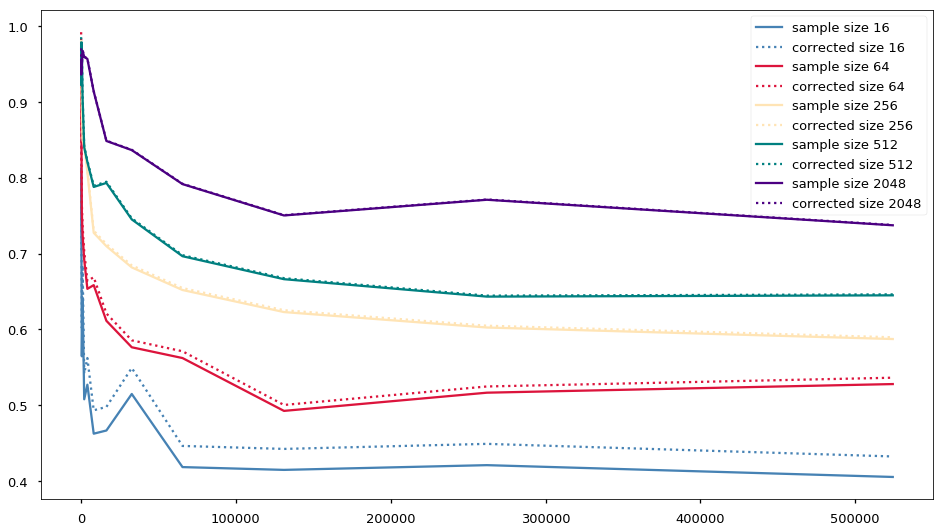

In [154]:
sample_sizes = [16, 64, 256, 512, 2048]
colors = ['steelblue', 'crimson', 'moccasin', 'teal', 'indigo']
fig, ax = plt.subplots(figsize=(16, 9))
for i, ssize in enumerate(sample_sizes):
    sizes = []
    ratios = []
    corrected = []
    for p_size in map(lambda x: 2**x, range(6, 20)):
        sizes.append(p_size)
        sr, src = std_ratio(p_size, sample_size=ssize, repeat=16)
        ratios.append(sr)
        corrected.append(src)
    ax.plot(sizes, ratios, label=f'sample size {ssize}', color=colors[i]);
    ax.plot(sizes, corrected, ':', label=f'corrected size {ssize}', color=colors[i]);
ax.legend();

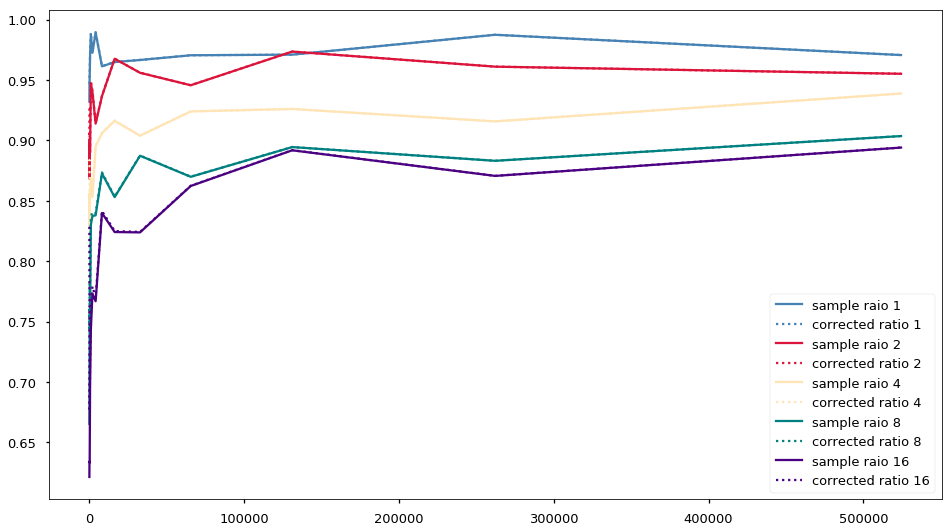

In [155]:
sample_ratios = [1, 2, 4, 8, 16]
colors = ['steelblue', 'crimson', 'moccasin', 'teal', 'indigo']
fig, ax = plt.subplots(figsize=(16, 9))
for i, rsize in enumerate(sample_ratios):
    sizes = []
    ratios = []
    corrected = []
    for p_size in map(lambda x: 2**x, range(6, 20)):
        sizes.append(p_size)
        sr, src = std_ratio(p_size, sample_ratio=rsize, repeat=16)
        ratios.append(sr)
        corrected.append(src)
    ax.plot(sizes, ratios, label=f'sample raio {rsize}', color=colors[i]);
    ax.plot(sizes, corrected, ':', label=f'corrected ratio {rsize}', color=colors[i]);
ax.legend();

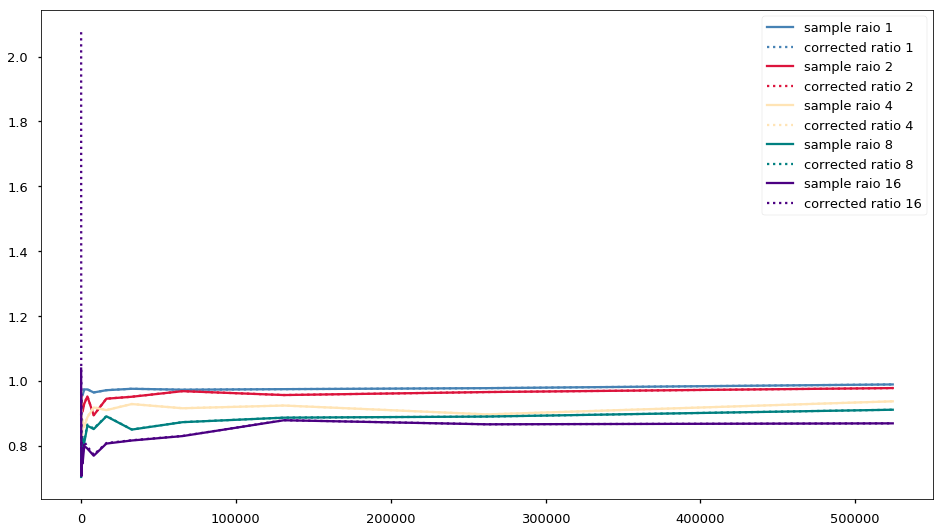

In [156]:
sample_ratios = [1, 2, 4, 8, 16]
colors = ['steelblue', 'crimson', 'moccasin', 'teal', 'indigo']
fig, ax = plt.subplots(figsize=(16, 9))
for i, rsize in enumerate(sample_ratios):
    sizes = []
    ratios = []
    corrected = []
    for p_size in map(lambda x: 2**x, range(6, 20)):
        sizes.append(p_size)
        sr, src = std_ratio(p_size, sample_ratio=rsize, repeat=16, dof=2)
        ratios.append(sr)
        corrected.append(src)
    ax.plot(sizes, ratios, label=f'sample raio {rsize}', color=colors[i]);
    ax.plot(sizes, corrected, ':', label=f'corrected ratio {rsize}', color=colors[i]);
ax.legend();

## Statistical Proof

We saw that using $n - 1$ is just a way of dealing with sample bias,
now we will try to find where the bias of the variance estimator comes from.

In a *population*, the variance of all values is exactly:

$$
\texttt{var}(X) = \texttt{cov}(X, X)
$$

This is because all measures in a population are independent of each other.

Yet, when we are sampling, the assumption that all measures are independent
is not true anymore.  There are various forms of correlation introduced by sampling.
The easiest correlation that one can see in sampling is in sampling without replacement:
If I'm sampling several measures out of a population at random and without replacement,
I first sample one measure from all measures in the population,
then I sample the next measure from all measures in the population minus the one
I already sampled.  The, for the third measure I sample form the set of all
measures of the population minus the two measures I already sampled, and so on.

In other words, the process of sampling introduces correlation between the sampled
measures.

Let's try to formalize the above.
For reasons that will become apparent later we will start with
the variance of the sum of the measures in a sample:

$$
\texttt{var} \left( \sum_{i=0}^{n} x_i \right) = \sum_{i=0}^{n} \sum_{j=0}^{n} \texttt{cov}(x_i, x_j)
$$

The right hand side is a double sum up to $n$.
We can take out one full sum by removing out of the right hand side term
every possibility where the sums would be summing together the same measure.
The remainder will be summing up across $i$ where it does not equal $j$
and across $j$ where it does not equal $i$.  We can simplify that:
since we will perform each sum twice we perform it once and multiply by $2$.
We now have:

$$
\texttt{var} \left( \sum_{i=0}^{n} x_i \right)
= \sum_{i=0}^{n} \texttt{cov}(x_i, x_i) + 2 \cdot \sum_{i<j<n} \texttt{cov}(x_i, x_j)
$$

Let's rewrite things a little on the right hand side.
The first term is just the variance, and the second we can write
in the way as we already said above: as a sum of every $i$ that is not
the same as $j$.

$$
\texttt{var} \left( \sum_{i=0}^{n} x_i \right)
= \sum_{i=0}^{n} \texttt{var}(x_i) + \sum_{i \neq j} \texttt{cov}(x_i, x_j)
$$

Now, if we argue that the correlation between the sampled measures is some $\lambda$,
we can say that the covariance times this $\lambda$ is the variance.
(This should make sense, since the correlation introduced by the sampling is
what makes the covariance between them be a biased estimator of the variance.)
With this in mind, we have (the $-1$ is for the case where $i = j$):

$$
\texttt{var} \left( \sum_{i=0}^{n} x_i \right) = s_n^2 + (n -1)s_n^2 \lambda
$$

For a moment let's forget about our equation and note that, for an entire population:

$$
\frac{\texttt{var} \left( \sum_{i=0}^{n} x_i \right)}{n}
= \texttt{var}(\mu)
= \frac{\sigma^2}{n}
$$

Therefore, if we divide our equation by $n$ we can simplify it further.
Let's try this:

$$
\texttt{var}(\bar{x}) = \frac{s_n^2}{n} + \frac{(n -1) s_n^2 \lambda}{n}
$$

Looking at this equation we can say that
**the variance of a sample is biased by**:

$$
\frac{(n - 1)\lambda}{n}
$$

Now we will assume $\lambda = 1$, based mostly on our earlier experiments.
The $\lambda$ in the equation above should be the estimate of the correlation
between the measures in the sample, yet estimating that is pretty difficult
therefore we will just assume a sensible value.

To revert the bias of the estimator we will take the inverse of the bias we found, i.e.:

$$
\begin{align}
s^2 &= \frac{n}{n - 1} s_n^2 \\
s^2 &= \frac{n}{n - 1} \left( \frac{1}{n} \sum_{i=0}^{n} (x_i - \bar{x})^2 \right) \\
s^2 &= \frac{1}{n - 1} \sum_{i=0}^{n} (x_i - \bar{x})^2 \\
\end{align}
$$

And we reach the sample variance equation.
Which we can argue is a best-effort at removing the sample bias
introduced during the sampling of the population.

## Formal Proof

We will attempt to calculate the expected discrepancy between
the population variance ($\sigma^2$) and the biased estimator of this
variance ($s_n^2$) based on the sample values.

Note: the expected value operator ($E[\:]$) treats its argument as a random variable
(a set of random values with some mean).  The operator assumes that if we retrieve
many values from the random variable we will reach the mean.

$$
\begin{align}
E[\sigma^2 - s_n^2] &= E \left[ \frac{1}{n} \sum_{i=0}^{n}(x_i - \mu)^2
                              + \frac{1}{n} \sum_{i=0}^{n}(x_i - \bar{x})^2 \right] \\
&= \frac{1}{n} E \left[
   \sum_{i=0}^{n} (x_i^2 - 2x_i\mu + \mu^2 - x_i^2 + 2x_i\bar{x} - \bar{x}^2) \right] \\
&= \frac{1}{n} E \left[
   \sum_{i=0}^{n} (2x_i(\bar{x} - \mu)) + \sum_{i=0}^{n} \mu^2 - \sum_{i=0}^{n} \bar{x}^2 \right] \\
&= \frac{1}{n} E \left[
   \sum_{i=0}^{n} (2x_i(\bar{x} - \mu)) + n\mu^2 - n\bar{x}^2 \right] \\
&= E \left[
   \frac{1}{n} \sum_{i=0}^{n} (2x_i(\bar{x} - \mu)) + \mu^2 - \bar{x}^2 \right] \\
&= E \left[ 2\bar{x}(\bar{x} - \mu) + \mu^2 - \bar{x}^2 \right] \\
&= E \left[ 2\bar{x}^2 - 2\bar{x}\mu + \mu^2 - \bar{x}^2 \right] \\
&= E \left[ \bar{x}^2 - 2\bar{x}\mu + \mu^2 \right] \\
&= E \left[ (\bar{x} - \mu)^2 \right] \\
&= \texttt{var}(\mu) \\
&= \frac{\sigma^2}{n}
\end{align}
$$

Now we have that the expected value of the biased estimator is
the value of the population variance minus the discrepancy between
the population variance and the biased estimator:

$$
s_n^2 = \sigma^2 - \frac{\sigma^2}{n} = \frac{(n - 1)\sigma^2}{n}
$$

Finally, the unbiased estimator can be found by inverting the bias:

$$
\begin{align}
s^2 &= \frac{n}{n - 1} s_n^2 \\
s^2 &= \frac{n}{n - 1} \left( \frac{1}{n} \sum_{i=0}^{n} (x_i - \bar{x})^2 \right) \\
s^2 &= \frac{1}{n - 1} \sum_{i=0}^{n} (x_i - \bar{x})^2 \\
\end{align}
$$

## References

- [Bessel's Correction][1]
- [Stats - How statistician's agree using (n - 1)?][2]
- [Joseph C. Watkins - Introduction to the Science of Statistics (chapter 14)][3]

[1]: https://en.wikipedia.org/wiki/Bessel%27s_correction
[2]: https://stats.stackexchange.com/questions/100041/how-exactly-did-statisticians-agree-to-using-n-1-as-the-unbiased-estimator-for
[3]: https://www.math.arizona.edu/~jwatkins/